In [29]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [30]:
import torch 
from QuantumWalkModule.OneDimensionQW import QW_base_pure
from QuantumWalkModule.Operator import Op
from QuantumWalkModule.StatesPreparation import *

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
sns.set_style("darkgrid")

In [33]:
class Experiment1(QW_base_pure):
    def __init__(self, dim : int, coin_conf : dict) -> None:
        self.dim = dim
        self.S = self.Step()
        self.C1, self.C2 = self.Coin(**coin_conf)
        self.S1, self.S2 = self.Step()
        self.U = self.S1 @ self.C1 @ self.S2 @ self.C2
        self.st_gen = States(self.dim)

    def Step(self) -> torch.tensor :
        right = torch.kron(torch.roll(torch.eye(self.dim),1,0), Op.s_l)
        right += torch.kron(torch.eye(self.dim),Op.s_r) 
        left = torch.kron(torch.roll(torch.eye(self.dim),-1,0), Op.s_r)
        left += torch.kron(torch.eye(self.dim),Op.s_l) 
        return right.to(torch.complex64),left.to(torch.complex64)
    
    def make_step(self, state):
        return self.U @ state
    
    def Coin(self, **kwargs) -> tuple:
        th_plus = kwargs.get("th1", np.pi/4)
        th_minus = kwargs.get("th2", np.pi/4)
        C_standard = lambda th : torch.tensor([[np.cos(th/2), -np.sin(th/2)], [np.sin(th/2), np.cos(th/2)]])
        bulk = torch.diag(torch.tensor([1 if i != 0 and  i != self.dim-1 else 0 for i in range(self.dim)]))
        boundary = torch.diag(torch.tensor([0 if i != 0 and  i != self.dim-1 else 1 for i in range(self.dim)]))
        C_plus = torch.kron(bulk,C_standard(th_plus)) + torch.kron(boundary, Op.sx)
        C_minus = torch.kron(bulk,C_standard(th_minus)) + torch.kron(boundary, Op.sx)
        return C_plus.to(torch.complex64), C_minus.to(torch.complex64)

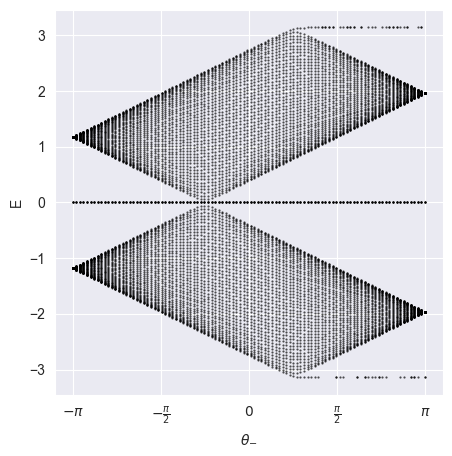

In [34]:
energies = []

x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']

th1 = np.pi/4
th2 = np.linspace(-np.pi, np.pi, 100)

for th2_ in th2:
    walk = Experiment1(50, {"th1": th1, "th2": th2_})
    U_ = walk.U
    data = np.sort(np.angle(torch.linalg.eigvals(U_).flatten().numpy()))
    energies.append(data) 

energies = np.array(energies)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(energies.shape[1]):
    ax.scatter(th2, energies[:,i], color='black', alpha=0.7, s = 0.3)
ax.set_xlabel(r"$\theta_{-}$")
ax.set_ylabel(r"E")
plt.xticks(x_tick, x_labs)
fig.savefig("Images/Energies1.pdf",format= "pdf",bbox_inches = "tight")


In [35]:
def get_eigen_info(walk2):
    U_ = walk2.U
    E,V = torch.linalg.eig(U_)
    E = (np.abs(np.angle(E.flatten().numpy())))
    indices = np.argsort(E)
    V = V[:,indices]
    E = E[indices]

    eps = 0.01

    E_zero = (E <0.01) * (E > -0.01)
    E_range = (E <3.14 + 0.01) * (E > 3.14 - 0.01)

    inds = E_zero + E_range

    V_eigs = V[:,inds]
    return E,E[inds], V_eigs

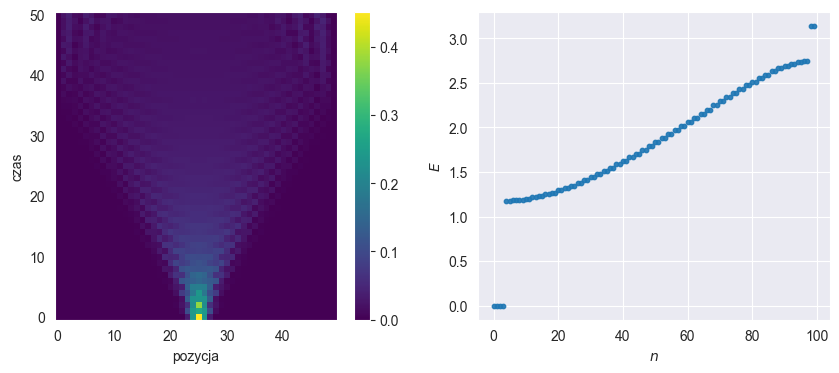

In [36]:
walk = Experiment1(50, {"th1": np.pi/4, "th2": np.pi/2})

data = walk.run(50)
E,E0,V_eigs = get_eigen_info(walk)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
cax = ax1.imshow(data,origin='lower', cmap='viridis', aspect='auto')
plt.grid(False)
fig.colorbar(cax)
ax1.set_ylabel("czas")
ax1.set_xlabel("pozycja")

ax = fig.add_subplot(122)
ax.scatter(range(len(E)),E, alpha=0.9, s = 10)
ax.set_ylabel(r"$E$")
ax.set_xlabel(r"$n$")

fig.savefig("Images/WalkDistribution.pdf",format= "pdf",bbox_inches = "tight")

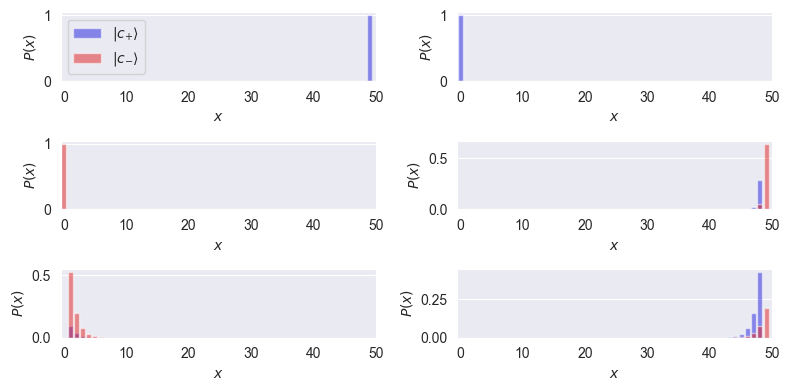

In [37]:
x_tick = [i * 10 for i in range(6)]
x_labs = list(map(str, x_tick))


fig = plt.figure(figsize=(8,4))
for index in range(len(E0)):
    ax = fig.add_subplot(len(E0) // 2,2,index +1)
    prob = np.abs(V_eigs[:,index])**2
    prob_plus = prob[0::2]
    prob_minus = prob[1::2]
    sns.barplot(prob_plus, color='blue', alpha=0.5, label = r"$|c_{+}\rangle$")
    sns.barplot(prob_minus, color='red', alpha=0.5, label = r"$|c_{-}\rangle$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$P(x)$")
    plt.xticks(x_tick, x_labs)
    if index == 0:
        plt.legend(loc='center left')
plt.tight_layout()
fig.savefig("Images/EdgeStates.pdf",format= "pdf",bbox_inches = "tight")

In [38]:
import sympy as sy

In [39]:
th_p, th_m = sy.symbols(r'\theta_{+}, \theta_{-}', complex=False)
k = sy.symbols(r'k')
rot = lambda th : sy.Matrix([[sy.cos(th/2), -sy.sin(th/2)], [sy.sin(th/2), sy.cos(th/2)]])
s_p = sy.Matrix([[sy.exp(-sy.I * k),0],[0,1]])
s_m = sy.Matrix([[1,0],[0,sy.exp(sy.I * k)]])


U_k = s_p * rot(th_p) * s_m * rot(th_m)

display(U_k)

Matrix([
[-sin(\theta_{+}/2)*sin(\theta_{-}/2) + exp(-I*k)*cos(\theta_{+}/2)*cos(\theta_{-}/2), -sin(\theta_{+}/2)*cos(\theta_{-}/2) - exp(-I*k)*sin(\theta_{-}/2)*cos(\theta_{+}/2)],
[  exp(I*k)*sin(\theta_{-}/2)*cos(\theta_{+}/2) + sin(\theta_{+}/2)*cos(\theta_{-}/2),   exp(I*k)*cos(\theta_{+}/2)*cos(\theta_{-}/2) - sin(\theta_{+}/2)*sin(\theta_{-}/2)]])

In [40]:
Ek = sy.symbols(r'E_{k}')
U_k_det = U_k - sy.exp(-sy.I * Ek) * sy.eye(2)

In [41]:
det_ = (sy.det(U_k_det))
det_ = det_.simplify() * sy.exp(sy.I * Ek)
cEk = (det_.simplify() - sy.exp(sy.I * Ek) - sy.exp(-sy.I * Ek) ) * 2

display(cEk)
sEk = 1- cEk ** 2
sEk.simplify()

-2*exp(I*k)*cos(\theta_{+}/2)*cos(\theta_{-}/2) + 4*sin(\theta_{+}/2)*sin(\theta_{-}/2) - 2*exp(-I*k)*cos(\theta_{+}/2)*cos(\theta_{-}/2)

-4*(exp(2*I*k)*cos(\theta_{+}/2)*cos(\theta_{-}/2) - 2*exp(I*k)*sin(\theta_{+}/2)*sin(\theta_{-}/2) + cos(\theta_{+}/2)*cos(\theta_{-}/2))**2*exp(-2*I*k) + 1

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
sns.set_style("darkgrid")

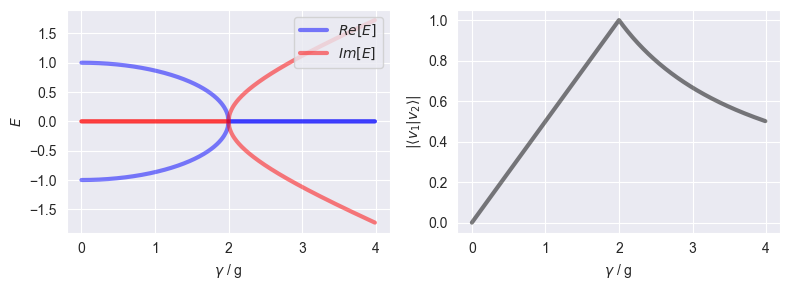

In [44]:
Heff = lambda g,gam : np.array([
    [1j * gam / 2, g],
    [g,-1j * gam / 2]
])

ratio = np.arange(0,4,0.01)
g = 1
Em = []
Ep = []
fid = []

for gam_ in ratio:
    H = Heff(g,gam_)
    E,V = np.linalg.eig(H)

    fid.append(np.abs((V[:,0].conj() * V[:,1]).sum()))

    Ep.append(E[0])
    Em.append(E[1])

Em = np.array(Em)
Ep = np.array(Ep)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121)
ax.plot(ratio, Em.real, color='blue', label = r"$Re[E]$", lw = 3, alpha = 0.5)
ax.plot(ratio, Ep.real, color='blue', lw = 3, alpha = 0.5)
ax.plot(ratio, Em.imag, color='red', label = r"$Im[E]$", lw = 3, alpha = 0.5)
ax.plot(ratio, Ep.imag, color='red', lw = 3, alpha = 0.5)
ax.set_xlabel(r"$\gamma$ / g")
ax.set_ylabel(r"$E$")
ax.legend(loc='upper right')

ax = fig.add_subplot(122)
ax.plot(ratio, fid, color='black', label = r"$Fidelity$", lw = 3, alpha = 0.5)
ax.set_xlabel(r"$\gamma$ / g")
ax.set_ylabel(r"$|\langle v_{1}|v_{2}\rangle|$")

plt.tight_layout()
fig.savefig("Images/EPcrossing.pdf",format= "pdf",bbox_inches = "tight")


In [45]:
class Experiment2(QW_base_pure):
    def __init__(self, dim : int, coin_conf : dict, electric_conf : dict) -> None:
        self.dim = dim
        self.S = self.Step()
        self.C1, self.C2 = self.Coin(**coin_conf)
        self.S1, self.S2 = self.Step()
        self.E = self.Electric(**electric_conf)
        self.U = self.E @ self.S1 @ self.C1 @ self.E @ self.S2 @ self.C2
        self.st_gen = States(self.dim)

    def Electric(self, **kwargs) -> torch.tensor:
        phi = kwargs.get("phi", np.pi)
        El = torch.diag(np.exp(1j * torch.arange(self.dim) * phi))
        return torch.kron(El, torch.eye(2))


    def Step(self) -> torch.tensor :
        right = torch.kron(torch.roll(torch.eye(self.dim),1,0), Op.s_l)
        right += torch.kron(torch.eye(self.dim),Op.s_r) 
        left = torch.kron(torch.roll(torch.eye(self.dim),-1,0), Op.s_r)
        left += torch.kron(torch.eye(self.dim),Op.s_l) 
        return right.to(torch.complex64),left.to(torch.complex64)
    
    def make_step(self, state):
        return self.U @ state
    
    def Coin(self, **kwargs) -> tuple:
        th_plus = kwargs.get("th1", np.pi/4)
        th_minus = kwargs.get("th2", np.pi/4)
        C_standard = lambda th : torch.tensor([[np.cos(th/2), -np.sin(th/2)], [np.sin(th/2), np.cos(th/2)]])
        bulk = torch.diag(torch.tensor([1 if i != 0 and  i != self.dim-1 else 0 for i in range(self.dim)]))
        boundary = torch.diag(torch.tensor([0 if i != 0 and  i != self.dim-1 else 1 for i in range(self.dim)]))
        C_plus = torch.kron(bulk,C_standard(th_plus)) + torch.kron(boundary, Op.sx)
        C_minus = torch.kron(bulk,C_standard(th_minus)) + torch.kron(boundary, Op.sx)
        return C_plus.to(torch.complex64), C_minus.to(torch.complex64)

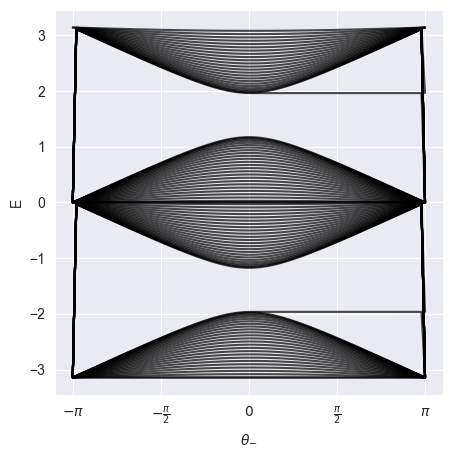

In [58]:
energies = []

x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']

th1 = np.pi/4
th2 = np.linspace(-np.pi, np.pi, 100)

for th2_ in th2:
    walk = Experiment2(50, {"th1": th1, "th2": th2_}, {"phi" :  np.pi})
    U_ = walk.U
    data = np.sort(np.angle(torch.linalg.eigvals(U_).flatten().numpy()))
    energies.append(data) 

energies = np.array(energies)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(energies.shape[1]):
    ax.plot(th2, energies[:,i], color='black', alpha=0.7)
    #ax.scatter(th2, energies[:,i], color='black', alpha=0.7, s = 0.3)
ax.set_xlabel(r"$\theta_{-}$")
ax.set_ylabel(r"E")
plt.xticks(x_tick, x_labs)
fig.savefig("Images/Energies1.pdf",format= "pdf",bbox_inches = "tight")